In [12]:
import torch
import pandas as pd
from random import shuffle
from wearsed.dataset.WearSEDDataset_MultiClass import WearSEDDataset

In [3]:
def get_random_start(labels, max_time, seq_length):
    start = torch.randint(0, max_time, (1,)).item()
    end = start + seq_length
    return start, labels[0, start:end].sum() < seq_length

def get_batch(signals, labels, batch_size, seq_length):
    (hypnogram, spo2, pleth) = signals
    max_time = labels.shape[1] - seq_length

    tries = 0
    random_starts = []
    while len(random_starts) < batch_size:
        random_start, has_positive_class = get_random_start(labels, max_time, seq_length)
        print(has_positive_class)
        if has_positive_class or tries >= batch_size // 2:
            random_starts.append(random_start)
        tries += 1
    shuffle(random_starts)

    batch_signals = []
    batch_labels = []
    for start in random_starts:
        end = start + seq_length
        seq_hypnogram = hypnogram[start:end].view((1, -1))
        seq_spo2 = spo2[start:end].view((1, -1))
        seq_pleth = pleth[start*256:end*256].view((256, -1))
        try:
            combined_signal = torch.cat([seq_hypnogram, seq_spo2, seq_pleth], dim=0)
        except:
            print(f'### FAIL at {start}')
            raise Exception(f'### FAIL at {start}')
        batch_signals.append(combined_signal)
        batch_labels.append(labels[:, start:end])

    return torch.stack(batch_signals), torch.stack(batch_labels)

def get_multi_batch(dataset, i, multi_batch_size, batch_size, seq_length):
    multi_batch_signals = []
    multi_batch_labels  = []
    for j in range(multi_batch_size):
        (hypnogram, spo2, pleth), target = dataset[multi_batch_size*i+j]
        try:
            batch_signal, batch_label = get_batch((hypnogram, spo2, pleth), target, batch_size, seq_length)
        except:
            print(f'### get_multi_batch at {i=}, {j=}')
            raise Exception(f'### get_multi_batch at {i=}, {j=}')
        multi_batch_signals.append(batch_signal)
        multi_batch_labels.append(batch_label)
    return torch.cat(multi_batch_signals), torch.cat(multi_batch_labels)

In [4]:
dataset = WearSEDDataset(mesaid_path='../wearsed/dataset/data_ids/', signals_to_read=['SpO2', 'Pleth'])

In [ ]:
x, y = get_multi_batch(dataset, 0, multi_batch_size=4, batch_size=32, seq_length=30*60)

In [6]:
y.shape

torch.Size([128, 4, 1800])

In [7]:
y[6, 0].sum()

tensor(1686)

In [8]:
x.shape

torch.Size([128, 258, 1800])

<Axes: >

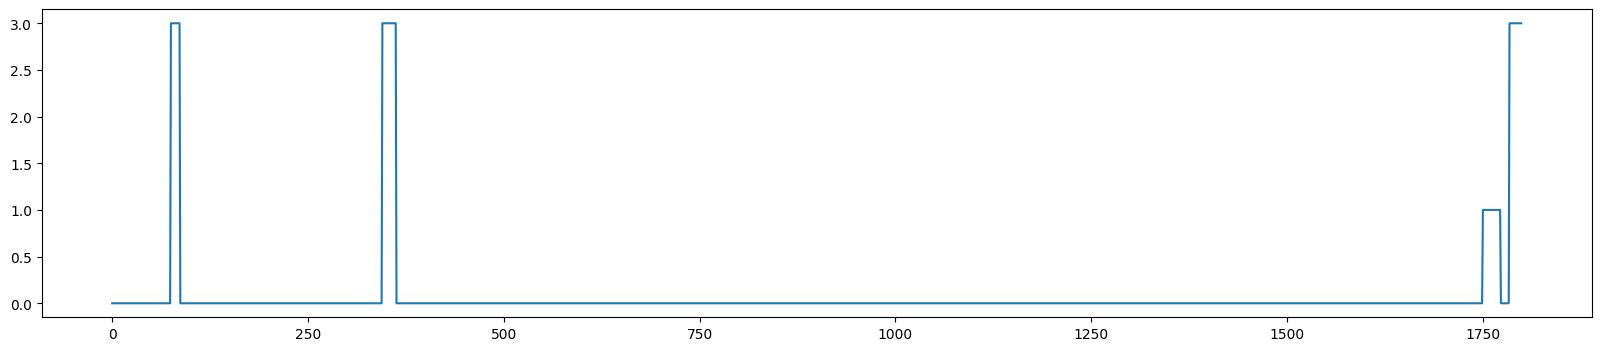

In [20]:
pd.Series(y.argmax(dim=1)[0]).plot(figsize=(20, 4))

<Axes: >

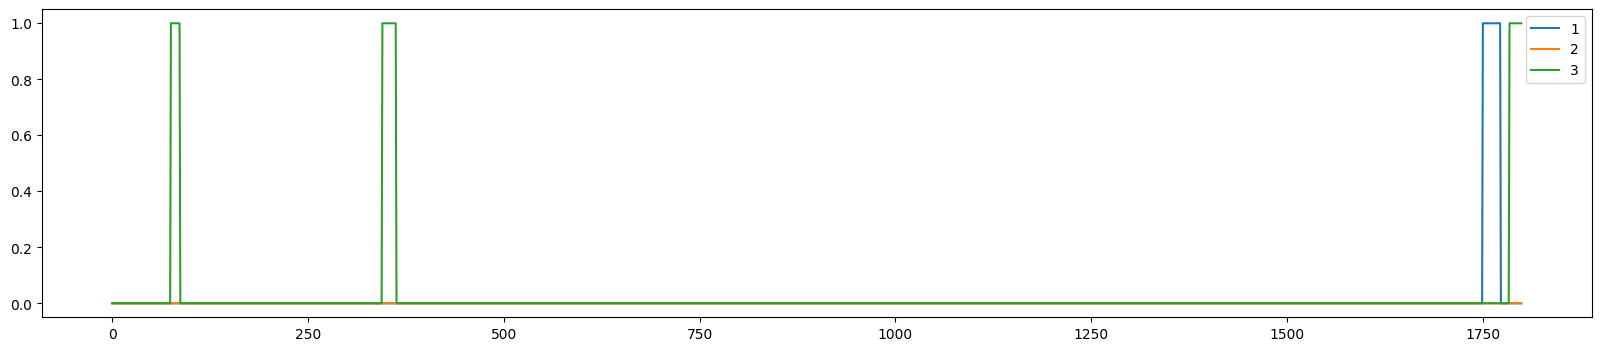

In [23]:
pd.DataFrame(y[0].T)[[1,2,3]].plot(figsize=(20, 4))